In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import matplotlib.pyplot as plt

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Libraries imported.


# 1. Gathering the data

### Let's download the 'Census Zip Codes in Colorado 2017' from the Colorado database.

In [2]:
file_census = 'https://data.colorado.gov/api/views/g598-t929/rows.csv'
df_cen = pd.read_csv(file_census)
print(df_cen.shape)
df_cen.head(5)

(526, 156)


,the_geom,zip_code,pop,hispanic,white_nh,black_nh,ntvam_nh,asian_nh,hawpi_nh,other_nh,...,civ_ni_pop,disabled,pop16_pls,laborforce,civ_lf,emp,unemp,armedfrcs,not_lf,civ_ni_p
0,MULTIPOLYGON (((-105.92702999963473 39.6767030...,80476,196,1,195,0,0,0,0,0,...,196,14,175,117,117,116,1,0,58,196
1,MULTIPOLYGON (((-106.83158099996315 40.4857409...,80477,146,0,146,0,0,0,0,0,...,146,10,136,48,48,48,0,0,88,146
2,MULTIPOLYGON (((-105.92671200025859 39.9919989...,80478,1625,14,1496,15,0,100,0,0,...,1625,0,1527,1153,1153,1110,43,0,374,1625
3,MULTIPOLYGON (((-106.98091500042688 40.0471639...,80479,5,0,5,0,0,0,0,0,...,5,0,5,5,5,5,0,0,0,5
4,MULTIPOLYGON (((-106.87322100014899 40.9736360...,80480,1342,335,997,0,5,0,0,0,...,1337,85,1067,707,707,694,13,0,360,1337


### Keep only the zipcode, number of children under 5 ('ageless5'), and the total population ('pop')

#### We could use the data to further explore what other variables can be used to describe Child Care Deserts, but for the scope of this project we will focus on the businesses of the zipcodes.

In [3]:
df_cen17 = df_cen[['zip_code', 'ageless5','pop']]
df_cen17.columns = ['zipcode', 'ageless5','pop']
df_cen17 = df_cen17.set_index('zipcode')

#zipcodes with no population droped becasue those are p.o. boxes
df_cen17 = df_cen17[(df_cen17[['pop']] != 0).all(1)]
print(df_cen17.shape)
df_cen17.head()

(516, 2)


,ageless5,pop
zipcode,,
80476,11,196
80477,0,146
80478,27,1625
80479,0,5
80480,89,1342


### I'd like to get the lat and longitude on each zipcopcode so I'll download that data. 

In [6]:
file_zipcd = 'co-zip-code-latitude-and-longitude.csv'
df_zipcd = pd.read_csv(file_zipcd)
df_zipcd = df_zipcd[['Zip', 'Latitude','Longitude']]
df_zipcd.columns = ['zipcode', 'Latitude', 'Longitude']
print(df_zipcd.shape)
print(df_zipcd.head(5))


(680, 3)
   zipcode   Latitude   Longitude
0    81148  37.171583 -105.986480
1    81423  38.082231 -108.258600
2    81505  39.112514 -108.605060
3    81624  39.220166 -107.934140
4    80402  39.522014 -105.223945


In [7]:
#merge lat long data with childzip numbers
df_childZipLat = pd.merge(df_cen17, df_zipcd, on='zipcode')
df_childZipLat = pd.merge(df_childZipLat, df_radiusZip, on='zipcode')

listZip = df_childZipLat['zipcode']
df_childZipLat.head()

NameError: name 'df_radiusZip' is not defined

### I am also interested in seeing if business density in a zipcode factors in somehow to CCD? So having an area variable will be useful. 
### I downloaded and caluculated a radius for each zipcode dependent on the actual area of the zipcode. This was done on ArcSis

In [19]:
file_radius = 'df_radiusList.csv'
df_radiusZip = pd.read_csv(file_radius)
df_radiusZip = df_radiusZip.drop(columns = ['Unnamed: 0'])
df_radiusZip.head()

,zipcode,radius_meters
0,80023,3400
1,80022,5400
2,80103,13600
3,80701,19800
4,80010,1800
5,81101,16300
6,80012,2200
7,80013,3000
8,81084,12500
9,81038,200


### Now I need to see how many child care providers are located in each zipcode and their capacity. Luckily Colorado keeps such a database. 

In [21]:
file_child = 'https://data.colorado.gov/api/views/a9rr-k8mu/rows.csv'
df_child = pd.read_csv(file_child)

#drop school age care center because desert is defined by lack of day care for under school age care
df_child = df_child[~df_child['PROVIDER SERVICE TYPE'].isin(['School-Age Child Care Center'])] 

### I'll clean the data and calculate the 'desert', 'not desert', and 'few children' classification for each zipcode. 

In [22]:

df_child = df_child[['ZIP','TOTAL LICENSED CAPACITY']]
#df_child.loc[80202]
#print(df_child.shape)
df_child.columns = ['zipcode','child capacity']
df_child = df_child.groupby('zipcode').sum()
df_child = df_child.loc[listZip].dropna()

df_childDesert = pd.merge(df_child, df_childZipLat, on='zipcode')
#df_childDesert.set_index('zipcode')
df_childDesert.head()
df_childDesert['Desert'] = np.where(((df_childDesert['ageless5']>30)&(((df_childDesert['ageless5'])/3)>=(df_childDesert['child capacity']))), 1, 0) #desert 1= yes
df_childDesert


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


,zipcode,child capacity,ageless5,pop,Latitude,Longitude,radius_meters,Desert
0,80477,203.0,0,146,40.348242,-106.926910,100,0
1,80478,39.0,27,1625,40.001670,-105.868600,5200,0
2,80480,15.0,89,1342,40.621621,-106.244570,31400,1
3,80481,486.0,6,601,40.106130,-105.480440,6800,0
4,80483,36.0,56,660,40.149432,-106.906810,7500,0
5,80487,594.0,702,17708,40.502772,-106.875210,21700,0
6,80498,96.0,333,7530,39.722417,-106.137440,13100,1
7,80501,2157.0,2994,41996,40.171484,-105.100330,2800,0
8,80503,558.0,1546,33811,40.156035,-105.173650,7800,0
9,80504,887.0,3598,52339,40.160138,-105.017720,8100,1


In [23]:
df_childDesert['Few_Child'] = np.where((df_childDesert['ageless5']<=30), 1, 0) #few kids  1=yes
df_childDesert

,zipcode,child capacity,ageless5,pop,Latitude,Longitude,radius_meters,Desert,Few_Child
0,80477,203.0,0,146,40.348242,-106.926910,100,0,1
1,80478,39.0,27,1625,40.001670,-105.868600,5200,0,1
2,80480,15.0,89,1342,40.621621,-106.244570,31400,1,0
3,80481,486.0,6,601,40.106130,-105.480440,6800,0,1
4,80483,36.0,56,660,40.149432,-106.906810,7500,0,0
5,80487,594.0,702,17708,40.502772,-106.875210,21700,0,0
6,80498,96.0,333,7530,39.722417,-106.137440,13100,1,0
7,80501,2157.0,2994,41996,40.171484,-105.100330,2800,0,0
8,80503,558.0,1546,33811,40.156035,-105.173650,7800,0,0
9,80504,887.0,3598,52339,40.160138,-105.017720,8100,1,0


In [24]:
df_childDesert['Not_Desert'] = np.where(((df_childDesert['ageless5']>30)&(((df_childDesert['ageless5'])/3)<(df_childDesert['child capacity']))), 1, 0) #not_desert 1= yes

In [25]:
df_childDesert

,zipcode,child capacity,ageless5,pop,Latitude,Longitude,radius_meters,Desert,Few_Child,Not_Desert
0,80477,203.0,0,146,40.348242,-106.926910,100,0,1,0
1,80478,39.0,27,1625,40.001670,-105.868600,5200,0,1,0
2,80480,15.0,89,1342,40.621621,-106.244570,31400,1,0,0
3,80481,486.0,6,601,40.106130,-105.480440,6800,0,1,0
4,80483,36.0,56,660,40.149432,-106.906810,7500,0,0,1
5,80487,594.0,702,17708,40.502772,-106.875210,21700,0,0,1
6,80498,96.0,333,7530,39.722417,-106.137440,13100,1,0,0
7,80501,2157.0,2994,41996,40.171484,-105.100330,2800,0,0,1
8,80503,558.0,1546,33811,40.156035,-105.173650,7800,0,0,1
9,80504,887.0,3598,52339,40.160138,-105.017720,8100,1,0,0


### I'm saving to a csv so I dont have to repeat everything each time I want to run an experiment on the data. 

In [26]:
df_childDesert.to_csv(r'df_childDesert.csv')

In [2]:
#can read in childDesert to prevent having to rerun notbook in entirity
df_childDesert = pd.read_csv('df_childDesert_Labeled.csv')

### Now I need the Foursquare data.

In [3]:
CLIENT_ID = 'IHJUPCIYEB15UKUR3XJYE1ZUSTBG0R400JRYV5F2TT05KIL4' # your Foursquare ID
CLIENT_SECRET = 'FV4GVLECGVUNBRR3H40TC250K25BL0FCJTV4BNOJQBW3O2IQ' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IHJUPCIYEB15UKUR3XJYE1ZUSTBG0R400JRYV5F2TT05KIL4
CLIENT_SECRET:FV4GVLECGVUNBRR3H40TC250K25BL0FCJTV4BNOJQBW3O2IQ


### Get the Colorado latitude and longitude using geolocator

In [4]:
address = 'COLORADO'

geolocator = Nominatim(user_agent="colorado_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Colorado are {}, {}.'.format(latitude, longitude))
#38.7251776, -105.6077167

The geograpical coordinates of Colorado are 38.7251776, -105.6077167.


### And create a map to visualize

In [5]:
# create map of colorado using latitude and longitude values
map_colorado = folium.Map(location=[latitude, longitude], zoom_start=6)

# add markers to map
for lat, lng, label in zip(df_childDesert['Latitude'], df_childDesert['Longitude'], df_childDesert['zipcode']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_colorado)  
    
map_colorado

### Now I will get the Venues located in the radius value I calculated previously. Limit of 500

In [33]:
def getNearbyVenues(names, latitudes, longitudes, radius, limit = 500):
    
    venues_list=[]
    for name, lat, lng, rad in zip(names, latitudes, longitudes, radius):
        print
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            rad, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['zipcode', 
                  'Zipcode Latitude', 
                  'Zipcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
def getNearbyVenuesRad(names, latitudes, longitudes, radius = 500, limit = 500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['zipcode', 
                  'Zipcode Latitude', 
                  'Zipcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### I'm printing out the zipcode as the venue 'ripper' is complete by foursquare

In [16]:
denver_venuesRad = getNearbyVenuesRad(names=df_childDesert['zipcode'],
                                latitudes=df_childDesert['Latitude'],
                                longitudes=df_childDesert['Longitude']
                                )
denver_venuesRad.shape

80477
80478
80480
80481
80483
80487
80498
80501
80503
80504
80510
80511
80512
80758
81001
81003
81004
81005
81006
81007
81008
81020
81022
81023
81025
81029
81030
81036
81039
81137
81040
81041
81047
81049
81050
81052
81054
81055
80918
80919
80920
80921
80922
80924
80925
80863
80864
80902
80903
80904
80905
80906
80907
80908
80909
80910
80911
80913
80915
80916
80917
81058
81063
81064
81067
81069
81073
81077
81082
81087
81089
81090
81091
81092
81101
81120
81121
81122
81123
81125
81129
81130
81132
81140
81143
81144
81146
81147
80521
80524
80525
80526
80528
80530
80534
80535
80536
80654
80701
80720
80537
80538
80540
80542
80543
80545
80547
80549
80723
80728
80729
80731
80734
80735
80736
80550
80601
80602
80603
80610
80611
80615
80620
80621
80737
80741
80742
80743
80744
80747
80623
80631
80634
80640
80642
80643
80644
80019
80020
80021
80022
80751
80757
80759
80801
80805
80807
80513
80514
80645
80651
80653
80026
80027
80030
80031
80033
80045
80102
80103
80104
80105
80106
80107
80108
80109
8011

(1454, 7)

In [17]:
denver_venuesRad.shape

(1454, 7)

In [15]:
denver_VENUE_DONT_TOUCH = denver_venues

In [16]:
# only call this not the above
denver_venues = denver_VENUE_DONT_TOUCH

### Looking at the results

In [18]:

print(denver_venuesRad.shape)
denver_venuesRad.head()
#denver_venues

(1454, 7)


,zipcode,Zipcode Latitude,Zipcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,80483,40.149432,-106.90681,Oak Tree Inn Yampa,40.150162,-106.907848,Hotel
1,80483,40.149432,-106.90681,Penny's Diner,40.150190,-106.907954,American Restaurant
2,80483,40.149432,-106.90681,Antlers Cafe and Bar,40.150200,-106.908676,Café
3,80483,40.149432,-106.90681,"Yampa, Colorado",40.150530,-106.902933,Trail
4,80487,40.502772,-106.87521,Snow Bowl,40.503863,-106.870372,Bowling Alley


In [34]:

print(denver_venues.shape)
denver_venues.head()
#denver_venues

(8344, 7)


,zipcode,Zipcode Latitude,Zipcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,80478,40.00167,-105.8686,Tabernash Tavern,39.992848,-105.843889,American Restaurant
1,80478,40.00167,-105.8686,Hot Tub Time Machine,39.995027,-105.868007,Mountain
2,80478,40.00167,-105.8686,Dashing Thru the Snow,39.988871,-105.880457,Stables
3,80478,40.00167,-105.8686,Strawberry Trails (BLM),40.003644,-105.844600,Trail
4,80478,40.00167,-105.8686,Snooty Coyote,39.993036,-105.845535,Liquor Store


### And saving

In [104]:
denver_venues.to_csv(r'denver_venues.csv')

In [22]:
denver_venues = pd.read_csv('denver_venues.csv')

#### I'm saving two different venue lists. The 'denver_venues' is with a radius variable, while 'denver_venuesRad' is with a constant radius of 500 meter so I can see if a clustering with K means imporves with either one. 

### I group the venues into their respective Colorado zipcode

In [19]:
denver_venuesRad.to_csv(r'denver_venuesRad.csv')
denver_venuesRad = pd.read_csv('denver_venuesRad.csv')

In [62]:
denver_venues.groupby('zipcode').count()

,Unnamed: 0,Zipcode Latitude,Zipcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
zipcode,,,,,,,
80002,24,24,24,24,24,24,24
80003,23,23,23,23,23,23,23
80004,16,16,16,16,16,16,16
80005,10,10,10,10,10,10,10
80007,8,8,8,8,8,8,8
80010,34,34,34,34,34,34,34
80011,70,70,70,70,70,70,70
80012,40,40,40,40,40,40,40
80013,50,50,50,50,50,50,50


In [20]:
denver_venuesRad.groupby('zipcode').count()

,Unnamed: 0,Zipcode Latitude,Zipcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
zipcode,,,,,,,
80002,3,3,3,3,3,3,3
80003,2,2,2,2,2,2,2
80004,2,2,2,2,2,2,2
80007,1,1,1,1,1,1,1
80010,14,14,14,14,14,14,14
...,...,...,...,...,...,...,...
81615,12,12,12,12,12,12,12
81620,17,17,17,17,17,17,17
81632,1,1,1,1,1,1,1


In [23]:
print('There are {} uniques categories with a variable radius.'.format(len(denver_venues['Venue Category'].unique())))
print('There are {} uniques categories with a constant radius of 500 meters.'.format(len(denver_venuesRad['Venue Category'].unique())))

There are 409 uniques categories with a variable radius.
There are 250 uniques categories with a constant radius of 500 meters.


### One hot encoding the venue types in each zipcode to find clusters

In [40]:
# one hot encoding
denver_onehot = pd.get_dummies(denver_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
denver_onehot['zipcode'] = denver_venues['zipcode'] 

# move neighborhood column to the first column
fixed_columns = [denver_onehot.columns[-1]] + list(denver_onehot.columns[:-1])
denver_onehot = denver_onehot[fixed_columns]
print(denver_onehot.shape)
denver_onehot.head()

(8343, 410)


,zipcode,ATM,Accessories Store,Adult Boutique,Advertising Agency,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,...,Water Park,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,80478,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,80478,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,80478,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,80478,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,80478,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Doing the same for a constant radius

In [24]:
# one hot encoding
denver_onehotRad = pd.get_dummies(denver_venuesRad[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
denver_onehotRad['zipcode'] = denver_venuesRad['zipcode'] 

# move neighborhood column to the first column
fixed_columnsRad = [denver_onehotRad.columns[-1]] + list(denver_onehotRad.columns[:-1])
denver_onehotRad = denver_onehotRad[fixed_columnsRad]
print(denver_onehotRad.shape)
denver_onehotRad.head()

(1454, 251)


,zipcode,Accessories Store,Advertising Agency,Airport Service,Alternative Healer,American Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,80483,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,80483,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,80483,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,80483,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,80487,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
denver_grouped = denver_onehot.groupby('zipcode').mean().reset_index()

num_top_venues = 5

for zipcd in denver_grouped['zipcode']:
    #print("----"+str(zipcd)+"----")
    temp = denver_grouped[denver_grouped['zipcode'] == zipcd].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)
    
denver_grouped

,zipcode,ATM,Accessories Store,Adult Boutique,Advertising Agency,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,...,Water Park,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,80002,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.000,0.0,0.0,0.0
1,80003,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.000,0.0,0.0,0.0
2,80004,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.000,0.0,0.0,0.0
3,80005,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.000,0.0,0.0,0.0
4,80007,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,81648,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.000,0.0,0.0,0.0
343,81650,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.125,0.0,0.0,0.0
344,81652,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.000,0.0,0.0,0.0
345,81654,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.000,0.0,0.0,0.0


In [25]:
denver_groupedRad = denver_onehotRad.groupby('zipcode').mean().reset_index()

num_top_venues = 5

for zipcd in denver_groupedRad['zipcode']:
    #print("----"+str(zipcd)+"----")
    temp = denver_groupedRad[denver_groupedRad['zipcode'] == zipcd].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)
    
denver_groupedRad

,zipcode,Accessories Store,Advertising Agency,Airport Service,Alternative Healer,American Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,80002,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,80003,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,80004,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,80007,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,80010,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,81615,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
189,81620,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
190,81632,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
191,81639,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1]:
# uncomment if running above code again
#denver_grouped.to_csv(r'denver_grouped2.csv')

#uncomment if only running data below
#denver_grouped = pd.read_csv('denver_grouped.csv')

In [26]:
# uncomment if running above code again
denver_groupedRad.to_csv(r'denver_grouped2Rad.csv')

#uncomment if only running data below
#denver_grouped = pd.read_csv('denver_grouped.csv')

In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [66]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['zipcode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
zipcodes_venues_sorted = pd.DataFrame(columns=columns)
zipcodes_venues_sorted['zipcode'] = denver_grouped['zipcode']

for ind in np.arange(denver_grouped.shape[0]):
    zipcodes_venues_sorted.iloc[ind, 1:] = return_most_common_venues(denver_grouped.iloc[ind, :], num_top_venues)

zipcodes_venues_sorted

,zipcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,80002,Park,Fast Food Restaurant,Asian Restaurant,Mexican Restaurant,Pizza Place,Italian Restaurant,Sandwich Place,Big Box Store,Burger Joint,Discount Store
1,80003,Park,Fast Food Restaurant,Ramen Restaurant,Home Service,Baseball Field,Bank,Chinese Restaurant,Coffee Shop,Big Box Store,Mobile Phone Shop
2,80004,Frozen Yogurt Shop,Laundromat,Bakery,Mexican Restaurant,Gym,Chinese Restaurant,Fast Food Restaurant,Tennis Court,Grocery Store,Pharmacy
3,80005,Sandwich Place,Construction & Landscaping,Baseball Field,Pet Service,Fast Food Restaurant,Gym,Pizza Place,Liquor Store,Bank,Convenience Store
4,80007,Park,Bar,Museum,Event Space,Gym,Lake,Golf Course,Business Service,Zoo,Fondue Restaurant
5,80010,Mexican Restaurant,Fast Food Restaurant,Chinese Restaurant,Discount Store,Convenience Store,Theater,Sandwich Place,Clothing Store,Marijuana Dispensary,Bakery
6,80011,Fast Food Restaurant,Convenience Store,Mexican Restaurant,Chinese Restaurant,Breakfast Spot,Sandwich Place,Gas Station,Fried Chicken Joint,Shipping Store,Grocery Store
7,80012,Mexican Restaurant,Chinese Restaurant,Pizza Place,Thai Restaurant,Hotel,Breakfast Spot,Liquor Store,Gym / Fitness Center,Mobile Phone Shop,Fast Food Restaurant
8,80013,Sandwich Place,Coffee Shop,Convenience Store,Fast Food Restaurant,Dessert Shop,Locksmith,Grocery Store,Salon / Barbershop,Park,Pizza Place
9,80014,Hotel,Rental Car Location,Sandwich Place,Bar,Coffee Shop,Greek Restaurant,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant


In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['zipcode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
zipcodes_venues_sortedRad = pd.DataFrame(columns=columns)
zipcodes_venues_sortedRad['zipcode'] = denver_groupedRad['zipcode']

for ind in np.arange(denver_groupedRad.shape[0]):
    zipcodes_venues_sortedRad.iloc[ind, 1:] = return_most_common_venues(denver_groupedRad.iloc[ind, :], num_top_venues)

zipcodes_venues_sortedRad

,zipcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,80002,Park,Other Repair Shop,Construction & Landscaping,Yoga Studio,Fast Food Restaurant,Financial or Legal Service,Flea Market,Flower Shop,Food,Food Court
1,80003,Sporting Goods Shop,Sandwich Place,Farm,Fried Chicken Joint,French Restaurant,Forest,Football Stadium,Food Truck,Food Service,Food Court
2,80004,Public Art,Convenience Store,Yoga Studio,Farm,French Restaurant,Forest,Football Stadium,Food Truck,Food Service,Food Court
3,80007,Construction & Landscaping,Yoga Studio,Farm,Fried Chicken Joint,French Restaurant,Forest,Football Stadium,Food Truck,Food Service,Food Court
4,80010,Mexican Restaurant,Fast Food Restaurant,Pizza Place,Convenience Store,Food Truck,Marijuana Dispensary,Coffee Shop,Park,Fried Chicken Joint,Cosmetics Shop
...,...,...,...,...,...,...,...,...,...,...,...
188,81615,Grocery Store,Restaurant,Hotel,Pizza Place,Cosmetics Shop,Sporting Goods Shop,Cajun / Creole Restaurant,Ski Lodge,Liquor Store,Resort
189,81620,Grocery Store,Mexican Restaurant,Pizza Place,Bakery,Sporting Goods Shop,Furniture / Home Store,Sushi Restaurant,Shipping Store,Liquor Store,Sandwich Place
190,81632,Nightlife Spot,Yoga Studio,Farmers Market,Fried Chicken Joint,French Restaurant,Forest,Football Stadium,Food Truck,Food Service,Food Court
191,81639,Historic Site,Yoga Studio,Farm,Fried Chicken Joint,French Restaurant,Forest,Football Stadium,Food Truck,Food Service,Food Court


#### Save everything so i can run expirements without having to rerun the whole notebook and use the results in another notebook

In [68]:
zipcodes_venues_sorted.to_csv(r'zipcodes_venues_sorted.csv')

In [30]:
zipcodes_venues_sortedRad.to_csv(r'zipcodes_venues_sortedRad.csv')

In [31]:
#use this to not have to rerun zipcodes venues sorted
#zipcodes_venues_sorted = pd.read_csv('zipcodes_venues_sorted.csv')
df_childDesert = pd.read_csv('df_childDesert_Labeled.csv')

# Part 3. Clustering using K-Means

#### Using the elbow method I attempt to see if there is a particular K that results in good results.

In [33]:
from sklearn.cluster import KMeans
!conda install -c districtdatalabs yellowbrick --yes
from yellowbrick.cluster import KElbowVisualizer

print('KCluster Libraries Installed')


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - yellowbrick


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    matplotlib-2.2.2           |   py36hb69df0a_2         6.6 MB
    pytest-5.0.1               |           py36_0         353 KB
    packaging-19.1             |           py36_0          46 KB
    yellowbrick-1.0            |           py36_0         429 KB  districtdatalabs
    atomicwrites-1.3.0         |           py36_1          13 KB
    more-itertools-7.2.0       |           py36_0          99 KB
    pyqt-5.6.0                 |   py36h22d08a2_6         5.4 MB
    importlib_metadata-0.19    |           py36

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


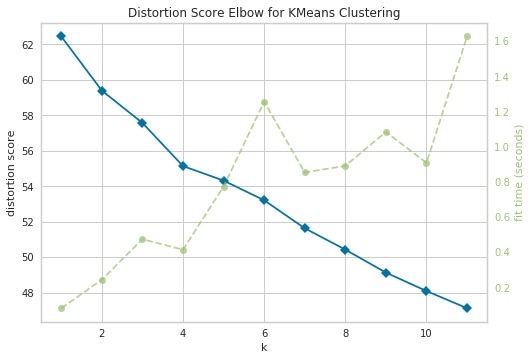

In [46]:
denver_grouped_clustering = denver_grouped.drop('zipcode', 1)
denver_grouped_clustering = denver_grouped_clustering.reset_index(drop=True)
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))

visualizer.fit(denver_grouped_clustering)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [48]:
denver_grouped_clustering.head()

,ATM,Accessories Store,Adult Boutique,Advertising Agency,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,Alternative Healer,...,Water Park,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


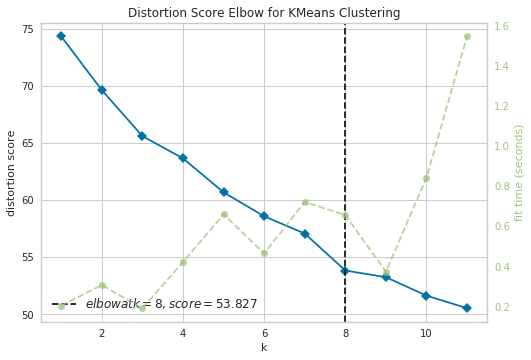

In [49]:
denver_grouped_clusteringRad = denver_groupedRad.drop('zipcode', 1)
denver_grouped_clusteringRad = denver_grouped_clusteringRad.reset_index(drop=True)
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))

visualizer.fit(denver_grouped_clusteringRad)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [50]:
denver_grouped_clusteringRad

,Accessories Store,Advertising Agency,Airport Service,Alternative Healer,American Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
189,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
190,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
191,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### There doesn't seem to be a great K value to cluster at best when using a variable radius. It would show an 'elbow' where the distortion is lowered and the fit time grown indicating a good K value. 
#### I think there is such a great venue collection size that it starts looking homogeneous and we cant really compare that way. 
#### Retrying to collecting the venues from the same radius size converges to k=8 as the optimum according to the elbow method. 

In [51]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(denver_grouped_clusteringRad)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 4, 4, 1, 4, 4, 4, 2, 4, 2], dtype=int32)

#### We merge the results here to create a dataframe with all the data we will need to look at possible correlations between Child Care Deserts and business types or numbe/density in a zipcode. 

In [52]:
# add clustering labels
zipcodes_venues_sortedRad.insert(0, 'Cluster Labels', kmeans.labels_)

denver_mergedRad = df_childDesert

# merge Colorado_grouped with Colorado_data to add latitude/longitude for each neighborhood
denver_mergedRad = denver_mergedRad.join(zipcodes_venues_sortedRad.set_index('zipcode'), on='zipcode')
denver_mergedRad = denver_mergedRad.dropna()
denver_mergedRad # check the last columns!


,Unnamed: 0,Unnamed: 0.1,zipcode,child capacity,ageless5,pop,Latitude,Longitude,radius_meters,Desert,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,4,4,80483,36.0,56,660,40.149432,-106.90681,7500,0,...,Hotel,American Restaurant,Trail,Café,Yoga Studio,Food,Fast Food Restaurant,Financial or Legal Service,Flea Market,Flower Shop
5,5,5,80487,594.0,702,17708,40.502772,-106.87521,21700,0,...,Campground,Bowling Alley,Breakfast Spot,Auto Workshop,Food Service,Flea Market,Flower Shop,Food,Food Court,Yoga Studio
7,7,7,80501,2157.0,2994,41996,40.171484,-105.10033,2800,0,...,Convenience Store,American Restaurant,Coffee Shop,Pizza Place,Brewery,Smoke Shop,Skating Rink,Cajun / Creole Restaurant,Sandwich Place,Chinese Restaurant
8,8,8,80503,558.0,1546,33811,40.156035,-105.17365,7800,0,...,Gym / Fitness Center,Yoga Studio,Farmers Market,Fried Chicken Joint,French Restaurant,Forest,Football Stadium,Food Truck,Food Service,Food Court
9,9,9,80504,887.0,3598,52339,40.160138,-105.01772,8100,1,...,Gun Range,Gym,Gym / Fitness Center,Yoga Studio,Frozen Yogurt Shop,French Restaurant,Forest,Football Stadium,Food Truck,Food Service
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,357,357,80465,234.0,695,16204,39.620748,-105.18121,5400,0,...,Golf Course,Yoga Studio,Farmers Market,Fried Chicken Joint,French Restaurant,Forest,Football Stadium,Food Truck,Food Service,Food Court
358,358,358,80466,97.0,132,3456,39.964486,-105.50805,7600,0,...,Coffee Shop,Indian Restaurant,Convenience Store,Supermarket,Thai Restaurant,Bakery,Restaurant,Jewelry Store,Brewery,Plaza
366,366,366,80825,15.0,47,503,38.765737,-102.78889,20700,1,...,Bank,Grocery Store,History Museum,Food,Fast Food Restaurant,Financial or Legal Service,Flea Market,Flower Shop,Yoga Studio,Farmers Market
368,368,368,80828,131.0,107,3597,39.273148,-103.69416,18700,0,...,Restaurant,Hotel,Stadium,Yoga Studio,Fast Food Restaurant,Financial or Legal Service,Flea Market,Flower Shop,Food,Food Service


In [53]:
colo_mergedRad = denver_mergedRad

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
colo_mergedRad = denver_mergedRad.join(denver_groupedRad.set_index('zipcode'), on='zipcode')
colo_mergedRad = colo_mergedRad.drop('Unnamed: 0',1)
colo_mergedRad = colo_mergedRad.drop('Unnamed: 0.1',1)
colo_mergedRad # check the last columns!


,zipcode,child capacity,ageless5,pop,Latitude,Longitude,radius_meters,Desert,Few_Child,Not_Desert,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
4,80483,36.0,56,660,40.149432,-106.90681,7500,0,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,80487,594.0,702,17708,40.502772,-106.87521,21700,0,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,80501,2157.0,2994,41996,40.171484,-105.10033,2800,0,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,80503,558.0,1546,33811,40.156035,-105.17365,7800,0,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,80504,887.0,3598,52339,40.160138,-105.01772,8100,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,80465,234.0,695,16204,39.620748,-105.18121,5400,0,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
358,80466,97.0,132,3456,39.964486,-105.50805,7600,0,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
366,80825,15.0,47,503,38.765737,-102.78889,20700,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
368,80828,131.0,107,3597,39.273148,-103.69416,18700,0,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Save everything for use in later experiments

In [56]:
colo_mergedRad.to_csv(r'colo_mergedRad.csv')

### Make a map with the cluster labels

In [54]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(denver_mergedRad['Latitude'], denver_mergedRad['Longitude'], denver_mergedRad['zipcode'], denver_mergedRad['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
    


In [55]:
map_clusters

### Does grouping into Cluster Labels have any predictive affect for CCD?

In [12]:
colo_mergedRad = pd.read_csv('colo_mergedRad.csv')
colo_mergedRad  = colo_mergedRad [['Cluster Labels','Classification']]
colo_mergedRad.describe()

,Cluster Labels,Classification
count,193.000000,193.000000
mean,3.601036,2.347150
std,1.168777,0.912132
min,0.000000,1.000000
25%,4.000000,1.000000
50%,4.000000,3.000000
75%,4.000000,3.000000
max,7.000000,3.000000


In [9]:
colo_mergedRad.groupby(['Cluster Labels', 'Classification']).size()

Cluster Labels  Classification
0.0             1                  1
                2                  1
                3                  2
1.0             1                  3
                2                  1
                3                  6
2.0             1                  4
                3                 19
3.0             1                  1
                2                  1
                3                  1
4.0             1                 48
                2                  6
                3                 90
5.0             2                  1
                3                  3
6.0             3                  1
7.0             1                  1
                3                  3
dtype: int64

### Seventy Five percent are in Cluster 4. 

### Let's take a closer look and see if there are any Cluster labels that have child care desserts as a higher classification distribution. 

In [5]:
import seaborn as sns

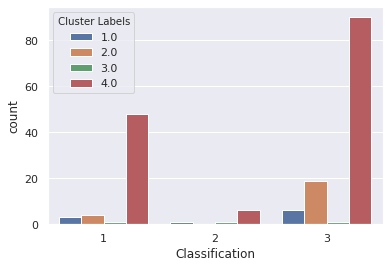

In [6]:
x14 = colo_mergedRad['Cluster Labels'].between(1, 4, inclusive=True)
x57 = colo_mergedRad['Cluster Labels'].between(5, 7, inclusive=True)

x14_colo = colo_mergedRad[x14]
x57_colo = colo_mergedRad[x57]
x14_colo
import seaborn as sns
sns.set(style="darkgrid")
ax14 = sns.countplot(x="Classification", hue = 'Cluster Labels', data=x14_colo)


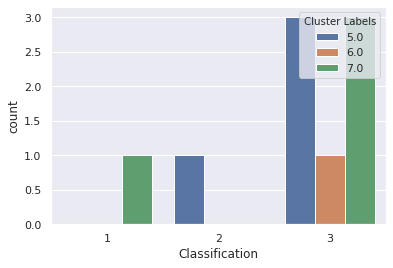

In [7]:
ax57 = sns.countplot(x="Classification", hue = 'Cluster Labels', data=x57_colo)

### They all have Classification 3 as the highest classification, indicating that Cluster Labels for business type is not a good indicator for CCD. 